In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


감독, 이름, 상영등급, 스태프 수 등의 정보로 영화 관객 수를 예측하는 모델을 만들어 주세요!

## 1. 라이브러리 및 데이터
## Library & Data

In [ ]:
import pandas as pd #판다스 패키지 불러오기
import lightgbm as lgb


In [ ]:
# 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON/MOVIES/data/movies_train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON/MOVIES/data/movies_test.csv')
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON/MOVIES/data/submission.csv')

In [ ]:
train['dir_prev_bfnum'].fillna(0,inplace=True)

In [ ]:
train.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
box_off_num       0
dtype: int64

In [ ]:
test.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

In [ ]:
test['dir_prev_bfnum'].fillna(0,inplace=True)

In [ ]:
test.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
dtype: int64

In [ ]:
import re

In [ ]:
train['distributor'] = train.distributor.str.replace("(주)", '')
test['distributor'] = test.distributor.str.replace("(주)", '')
train['distributor'] = train.distributor.str.replace(" ", '')
test['distributor'] = test.distributor.str.replace(" ", '')

In [ ]:
train['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

In [ ]:
def get_dis(x) :
    if 'CJ' in x or 'tvN' in x or '무비꼴라쥬' in x or 'CGV' in x :
        return 'CJ'
    elif '쇼박스' in x :
        return '쇼박스'
    elif 'SK' in x :
        return 'SK'
    elif '리틀빅픽' in x :
        return '리틀빅픽처스'
    elif '더픽쳐스' in x :
        return '리틀빅픽처스'
    elif '스폰지' in x :
        return '스폰지'
    elif '싸이더스' in x :
        return '싸이더스'
    elif '에이원' in x :
        return '에이원'
    elif '마인스' in x :
        return '마인스'
    elif '마운틴픽' in x :
        return '마운틴픽처스'
    elif '디씨드' in x :
        return '디씨드'
    elif '드림팩트' in x :
        return '드림팩트'
    elif '메가박스' in x :
        return '메가박스'
    elif '마운틴' in x :
        return '마운틴'
    else :
        return x

In [ ]:
train['distributor'] = train.distributor.apply(get_dis)
test['distributor'] = test.distributor.apply(get_dis)

In [ ]:
train.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
box_off_num       0
dtype: int64

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train['genre'] = le.fit_transform(train['genre'])

In [ ]:
test['genre'] = le.transform(test['genre'])

In [ ]:
pd_distributor = pd.concat([train['distributor'] ,test['distributor']], axis = 0,ignore_index=True) 
pd_distributor=le.fit_transform(pd_distributor)


In [ ]:
train['distributor'] = le.transform(train['distributor'])

In [ ]:
test['distributor'] = le.transform(test['distributor'])

In [ ]:
train['screening_rat'] = le.fit_transform(train['screening_rat'])

In [ ]:
test['screening_rat'] = le.transform(test['screening_rat'])

In [ ]:
pd_director = pd.concat([train['director'] ,test['director']], axis = 0,ignore_index=True) 


In [ ]:
pd_director=le.fit_transform(pd_director)


In [ ]:
train['director'] = le.transform(train['director'])

In [ ]:
test['director'] = le.transform(test['director'])

In [ ]:
train.describe()

,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,600.000000,600.000000,600.000000,600.000000,6.000000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,67.475000,4.776667,100.863333,1.663333,310.320000,4.726993e+05,0.876667,151.118333,3.706667,7.081818e+05
std,50.890954,2.841992,18.097528,1.115974,178.278985,1.309474e+06,1.183409,165.654671,2.446889,1.828006e+06
min,0.000000,0.000000,45.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,18.000000,3.000000,89.000000,1.000000,153.750000,0.000000e+00,0.000000,17.000000,2.000000,1.297250e+03
50%,63.000000,4.000000,100.000000,1.000000,311.500000,0.000000e+00,0.000000,82.500000,3.000000,1.259100e+04
75%,105.000000,5.000000,114.000000,3.000000,465.250000,3.761416e+05,2.000000,264.000000,4.000000,4.798868e+05
max,173.000000,11.000000,180.000000,3.000000,613.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


In [ ]:
# 상관계수를 직관적으로 보기위해 시각화
import seaborn as sns

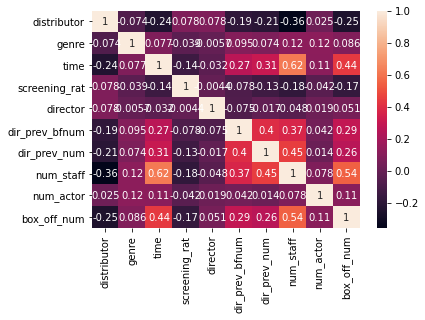

In [ ]:
#annot cell 값 표기여부 옵션
sns.heatmap(train.corr(), annot=True)

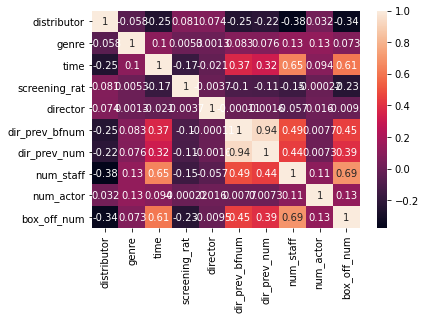

In [ ]:
#annot cell 값 표기여부 옵션
sns.heatmap(train.corr(method='spearman'), annot=True)

In [ ]:
features = ['time','dir_prev_num','num_staff','dir_prev_bfnum','genre','screening_rat','director','distributor'] 
target = ['box_off_num']

In [ ]:
X_train , X_test, y_train = train[features],test[features],train[target]

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
k_fold = KFold(n_splits=10,shuffle=True, random_state=111)

In [ ]:
# 하이퍼파라미터 (커널스케일, 박스컨스트레인트 등 모델파라미터를 의미) 의 최적값을 찾음
from sklearn.model_selection import GridSearchCV

In [ ]:
model = lgb.LGBMRegressor(random_state=111,objective = 'regression_l2',metric='rmse')
#learning_rate: 기존모델의 성능을 다음 모델에 얼만큼 영향을 줄것인지 가중치. 값이 적을수록 미세한영향
#min_child_samples : 최종 결정 클래스인 Leaf Node가 되기 위해서 최소한으로 필요한 데이터 개체의 수
params = { 
    'learning_rate' : [0.003,0.004,0.005,0.006],
    'min_child_samples' :[25,30,35,45,60] ,
    'n_estimators' : [600,700,800,900,1000]
    
    }
# 대회에서는 RMSE 가 평가지표이므로 scoring 을 neg_mean_squared_error 로 설정
gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  scoring = 'neg_mean_squared_error',
                  cv=k_fold) # 일반적으로 kfold를 사용하고 cv=5 해도 동일


In [ ]:
gs.fit(X_train,y_train)

In [ ]:
gs.best_params_

In [ ]:
import numpy as np
model=lgb.LGBMRegressor(random_state=111,n_estimators=500000,learning_rate= 0.5, min_child_samples= 30,objective = 'huber',metric='rmse')

models = []

# iloc : index로 접근 X_train.iloc[train_idx] : X_train의 train_idx 값에 해당하는 행
for train_idx,val_idx in k_fold.split(X_train):
  x_t = X_train.iloc[train_idx]
  y_t = y_train.iloc[train_idx]
  x_val = X_train.iloc[val_idx]
  y_val = y_train.iloc[val_idx]
  
  #eval_set : 검증용 set ,early_stopping_rounds : 과적합을 막기위해 어느단계에서 멈출지, n_estimators 만큼 반복하는데 early_stopping_rounds 만큼 성능의 증가(오차율감소)가 없다면 멈춤
  # verbose= 해당숫자만큼 진행했을때 진행과정 출력
  models.append(model.fit(x_t,(y_t),eval_set=(x_val,(y_val)),early_stopping_rounds=500000,verbose=100000))

In [ ]:
preds = []
for model in models:
  preds.append(model.predict(X_test))


In [ ]:

gsLGBM = submission.copy()
gsLGBM['box_off_num'] = np.mean((preds),axis=0)
gsLGBM['box_off_num']

0      819176.926872
1      729834.000000
2      870067.614556
3      810177.193382
4      736860.491066
           ...      
238    483115.842998
239    483115.842998
240    508876.497890
241    483115.842998
242    483115.842998
Name: box_off_num, Length: 243, dtype: float64

In [ ]:
gsLGBM.to_csv('gsLGBM_500000_05_30_l2_rmse_5.csv',index=False)